# Some regularizations and optimization algorithms on [California Housing Values](https://github.com/ageron/handson-ml/tree/master/datasets/housing) dataset
By [Zahra Taheri](https://github.com/zahta), November 26, 2020

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Set the seeds to ensure reproducibility
np.random.seed(1)
torch.manual_seed(1)

## Reading the dataset

In [2]:
data=pd.read_csv('housing.csv')
data.shape

(20640, 10)

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Descriptive statistics and data visualizations

In [5]:
#Describe the dataset

data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
#Check the no. of unique items in each categorical column

data.select_dtypes('object').nunique()

ocean_proximity    5
dtype: int64

In [7]:
# Percentage of missing data in each column

number_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


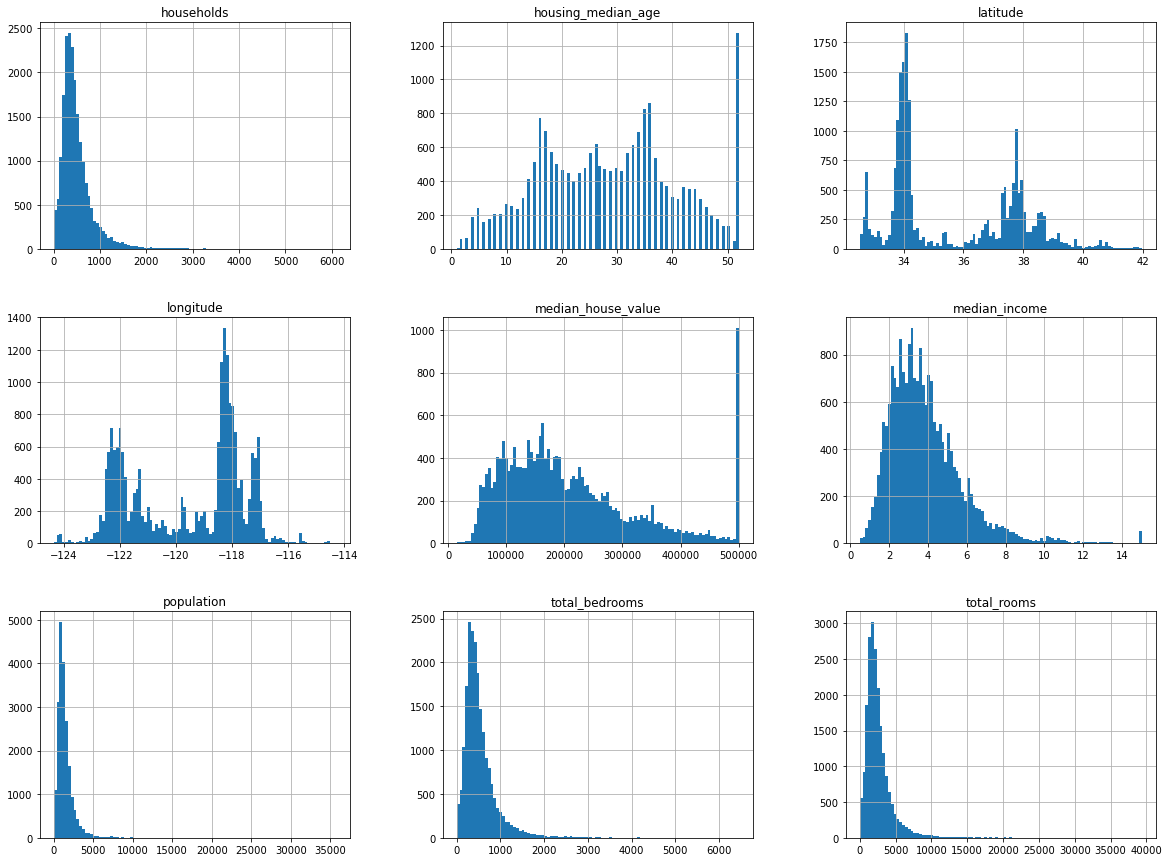

In [8]:
data.hist(bins=100, figsize=(20,15))

plt.show()

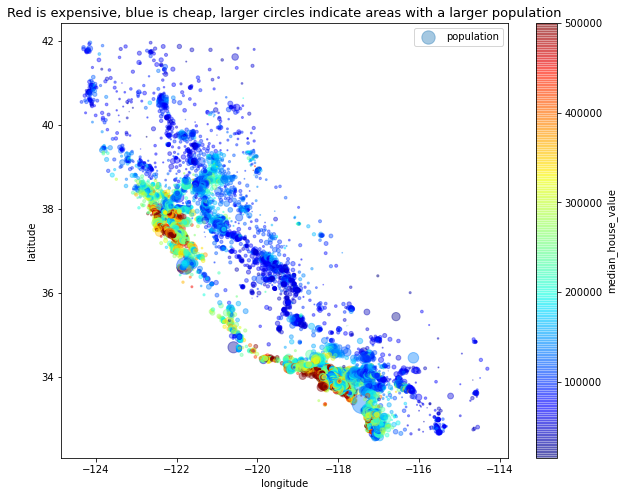

In [9]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data["population"]/100, label="population", figsize=(10,8),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.title('Red is expensive, blue is cheap, larger circles indicate areas with a larger population',\
          fontweight = 20, fontsize = 13)
plt.legend()

In [10]:
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Data Cleaning and Preparation

In [11]:
#Fill in missing values with median

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [12]:
#Remove the text attribute because median can only be calculated on numerical attributes:
data_num=data.drop("ocean_proximity", axis=1)

In [13]:
imputer.fit(data_num)
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [14]:
X = imputer.transform(data_num)
data_num_clean = pd.DataFrame(X, columns=data_num.columns,index=data_num.index)
data_num_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [15]:
data_num_clean["rooms_per_household"] = data_num_clean["total_rooms"]/data_num_clean["households"]
data_num_clean["bedrooms_per_room"] = data_num_clean["total_bedrooms"]/data_num_clean["total_rooms"]
data_num_clean["population_per_household"]=data_num_clean["population"]/data_num_clean["households"]

In [16]:
#Preprocess the categorical input feature, `ocean_proximity`:
data_cat = data[["ocean_proximity"]]

In [17]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)

In [18]:
data_num_clean["ocean_proximity"]=data_cat_encoded
data_clean=data_num_clean
data_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,3.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,3.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,3.0


In [19]:
housing_labels = data_clean["median_house_value"]
data_clean = data_clean.drop("median_house_value", axis=1)
data_clean["median_house_value"] = housing_labels
data_clean

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,6.984127,0.146591,2.555556,3.0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,6.238137,0.155797,2.109842,3.0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,8.288136,0.129516,2.802260,3.0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,5.817352,0.184458,2.547945,3.0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,6.281853,0.172096,2.181467,3.0,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,5.045455,0.224625,2.560606,1.0,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,6.114035,0.215208,3.122807,1.0,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,5.205543,0.215173,2.325635,1.0,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,5.329513,0.219892,2.123209,1.0,84700.0


In [20]:
from sklearn import preprocessing

minmax_scale = preprocessing.MinMaxScaler()
X_scaled = minmax_scale.fit_transform(data_clean)
X_scaled.shape

(20640, 13)

In [21]:
#Splitting the dependent and independent variables

X = X_scaled[:,:-1]
y = X_scaled[:,-1]

print(X.shape)
print(y.shape)

(20640, 12)
(20640,)


In [22]:
#Splitting the dataset into training and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(16512, 12)
(16512,)
(4128, 12)


In [23]:
train_data = train_data
test_data = test_data
train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

In [24]:
train_labels

array([[0.18144461],
       [0.75690616],
       [0.32494918],
       ...,
       [0.42701061],
       [0.55360803],
       [0.63917468]])

## Preparation of the dataset for PyTorch

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.tensor(train_data, dtype=torch.float).to(device) # transform to torch tensor
tensor_x2 = torch.tensor(test_data, dtype=torch.float).to(device) 

In [27]:
tensor_y = torch.tensor(train_labels, dtype=torch.float).to(device)
tensor_y2 = torch.tensor(test_labels, dtype=torch.float).to(device)

In [28]:
train_dataset = TensorDataset(tensor_x, tensor_y) # create your dataset
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [29]:
# Normalizing the data

#print(tensor_x,tensor_x2)

#mean = torch.mean(tensor_x)
#std = torch.std(tensor_x)

#tensor_x = (tensor_x - mean) / std
#tensor_x2 = (tensor_x2 - mean) / std

## Building Feedforward Neural Networks with PyTorch

In [30]:
def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            loss = criterion(outputs, targets)
            curr_loss += loss
        return float(curr_loss)/cnt

## Regularizations (Ensemble Methods)

- [Ensembles: the only (almost) free Lunch in Machine Learning](https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090)
    - Build optimal ensembles of neural networks with PyTorch and NumPy
    
    
- [Bagging and Dropout Learning](https://jrodthoughts.medium.com/bagging-and-dropout-learning-ae484023b0da)

### Dropout: Ensemble Method Interpretation
**Reference:** [Regularization by Sebastian Raschka](https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L10_regularization_slides.pdf)

- In DL, we typically don't do regular ensembling (majority vote over a large number of networks, bagging, etc.) because it is very expensive to fit neural nets.
- However, we know that the squared error for a prediction by a randomly selected model is larger than the squared error using an ensemble prediction (here, average over class probabilities).
- Now, in dropout, we have a different model for each minibatch. 
- Via the minibatch iterations, we essentially sample over $M=2^h$ models, where h is the number of hidden units.
- Restriction is that we have weight sharing over these models, which can be seen as a form of regularization.
- During "inference" we can then average over all these models (but this is very expensive). 
- However, using the last model after training and scaling the predictions by a factor 1/(1-p) approximates the geometric mean and is much cheaper (actually, it's exactly the geometric mean if we have a linear model).

### Dropout: More Practical Tips

- Don't use Dropout if your model does not overfit .
- However, in that case above, it is then recommended to increase the capacity to make it overfit, and then use dropout to be able to use a larger capacity model (but make it not overfit).



### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [110]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [111]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [112]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [113]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [114]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [115]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [116]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [117]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 2.8670
Epoch: 001/020 | Batch 1000/1032 | Loss: 0.6851
Epoch: 001/020 Train Loss: 0.8594
Time elapsed: 0.12 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.7729
Epoch: 002/020 | Batch 1000/1032 | Loss: 1.1948
Epoch: 002/020 Train Loss: 0.8206
Time elapsed: 0.23 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.5166
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.5068
Epoch: 003/020 Train Loss: 0.7771
Time elapsed: 0.35 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.5927
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.9110
Epoch: 004/020 Train Loss: 0.7277
Time elapsed: 0.46 min
Epoch: 005/020 | Batch 000/1032 | Loss: 1.1776
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.9773
Epoch: 005/020 Train Loss: 0.6726
Time elapsed: 0.58 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.4409
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.5002
Epoch: 006/020 Train Loss: 0.6160
Time elapsed: 0.70 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.8373
Epoch: 007/020 | Batch 1000/1032 | Loss: 

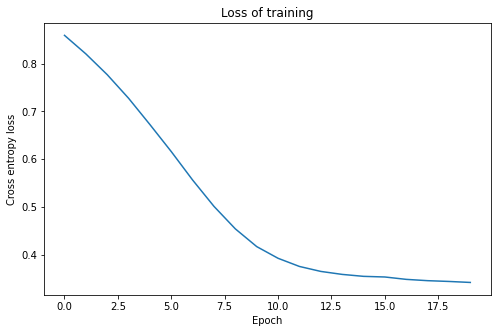

In [118]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 3 Hidden Layers Feedforward Neural Network (LeakyReLU activation)

### Create model class

In [127]:
batch_size = 16
n_iters = 40000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [128]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [129]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [130]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 100

In [131]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [132]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
         LeakyReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
         LeakyReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 100]         100,100
         LeakyReLU-7               [-1, 1, 100]               0
            Linear-8                 [-1, 1, 1]             101
Total params: 607,701
Trainable params: 607,701
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.32
Estimated Total Size (MB): 2.35
----------------------------------------------------------------


In [133]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [134]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/038 | Batch 000/1032 | Loss: 4.2848
Epoch: 001/038 | Batch 1000/1032 | Loss: 1.0356
Epoch: 001/038 Train Loss: 0.8557
Time elapsed: 0.14 min
Epoch: 002/038 | Batch 000/1032 | Loss: 0.9568
Epoch: 002/038 | Batch 1000/1032 | Loss: 1.1189
Epoch: 002/038 Train Loss: 0.8269
Time elapsed: 0.27 min
Epoch: 003/038 | Batch 000/1032 | Loss: 0.5307
Epoch: 003/038 | Batch 1000/1032 | Loss: 0.9702
Epoch: 003/038 Train Loss: 0.7959
Time elapsed: 0.41 min
Epoch: 004/038 | Batch 000/1032 | Loss: 0.4369
Epoch: 004/038 | Batch 1000/1032 | Loss: 0.5265
Epoch: 004/038 Train Loss: 0.7639
Time elapsed: 0.54 min
Epoch: 005/038 | Batch 000/1032 | Loss: 0.6899
Epoch: 005/038 | Batch 1000/1032 | Loss: 0.5823
Epoch: 005/038 Train Loss: 0.7303
Time elapsed: 0.68 min
Epoch: 006/038 | Batch 000/1032 | Loss: 0.8769
Epoch: 006/038 | Batch 1000/1032 | Loss: 0.5204
Epoch: 006/038 Train Loss: 0.6920
Time elapsed: 0.82 min
Epoch: 007/038 | Batch 000/1032 | Loss: 0.6923
Epoch: 007/038 | Batch 1000/1032 | Loss: 

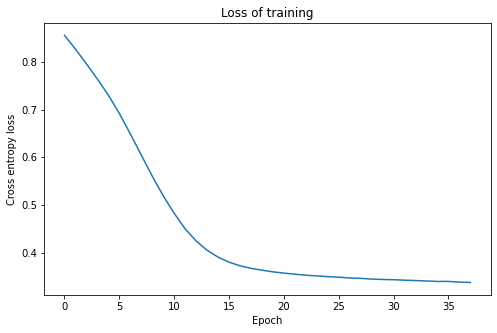

In [135]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 5 Hidden Layers Feedforward Neural Network

### Create model class

In [144]:
batch_size = 16
n_iters = 40000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

38


In [145]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [146]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.dropout2 = nn.Dropout(0.4)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(hidden_dim4, hidden_dim5)
        self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(hidden_dim5, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.dropout2(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        out = self.linear6(out)
        return out
    

In [147]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200
hidden_dim4 = 100
hidden_dim5 = 10

In [148]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [149]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8               [-1, 1, 100]          20,100
           Dropout-9               [-1, 1, 100]               0
             ReLU-10               [-1, 1, 100]               0
           Linear-11                [-1, 1, 10]           1,010
             ReLU-12                [-1, 1, 10]               0
           Linear-13                 [-1, 1, 1]              11
Total params: 728,821
Trainable params:

In [150]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.001
LAMBDA = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [151]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/038 | Batch 000/1032 | Loss: 1.2100
Epoch: 001/038 | Batch 1000/1032 | Loss: 0.6147
Epoch: 001/038 Train Loss: 0.9071
Time elapsed: 0.17 min
Epoch: 002/038 | Batch 000/1032 | Loss: 0.4168
Epoch: 002/038 | Batch 1000/1032 | Loss: 0.8889
Epoch: 002/038 Train Loss: 0.8978
Time elapsed: 0.34 min
Epoch: 003/038 | Batch 000/1032 | Loss: 0.8744
Epoch: 003/038 | Batch 1000/1032 | Loss: 0.3216
Epoch: 003/038 Train Loss: 0.8509
Time elapsed: 0.50 min
Epoch: 004/038 | Batch 000/1032 | Loss: 0.8203
Epoch: 004/038 | Batch 1000/1032 | Loss: 0.8723
Epoch: 004/038 Train Loss: 0.6370
Time elapsed: 0.66 min
Epoch: 005/038 | Batch 000/1032 | Loss: 0.7869
Epoch: 005/038 | Batch 1000/1032 | Loss: 0.2395
Epoch: 005/038 Train Loss: 0.3657
Time elapsed: 0.82 min
Epoch: 006/038 | Batch 000/1032 | Loss: 0.4101
Epoch: 006/038 | Batch 1000/1032 | Loss: 0.1918
Epoch: 006/038 Train Loss: 0.3342
Time elapsed: 0.99 min
Epoch: 007/038 | Batch 000/1032 | Loss: 0.2746
Epoch: 007/038 | Batch 1000/1032 | Loss: 

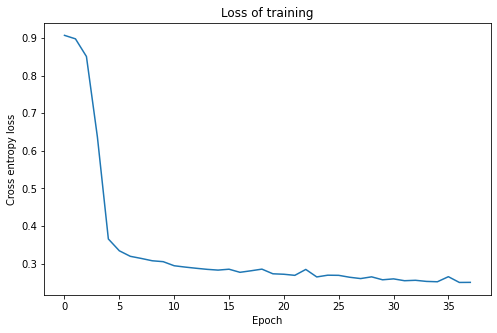

In [153]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## **Optimization:** Different optimizers and batch normalization

## 1. SGD

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [31]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [32]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [33]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [34]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [35]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [36]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [37]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [38]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 6.4782
Epoch: 001/020 | Batch 1000/1032 | Loss: 1.1225
Epoch: 001/020 Train Loss: 0.8286
Time elapsed: 0.11 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.5235
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.6322
Epoch: 002/020 Train Loss: 0.7760
Time elapsed: 0.23 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.7812
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.3524
Epoch: 003/020 Train Loss: 0.7216
Time elapsed: 0.34 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.4779
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.8093
Epoch: 004/020 Train Loss: 0.6638
Time elapsed: 0.47 min
Epoch: 005/020 | Batch 000/1032 | Loss: 1.1290
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.9608
Epoch: 005/020 Train Loss: 0.6031
Time elapsed: 0.66 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.2253
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.3445
Epoch: 006/020 Train Loss: 0.5417
Time elapsed: 0.83 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.2193
Epoch: 007/020 | Batch 1000/1032 | Loss: 

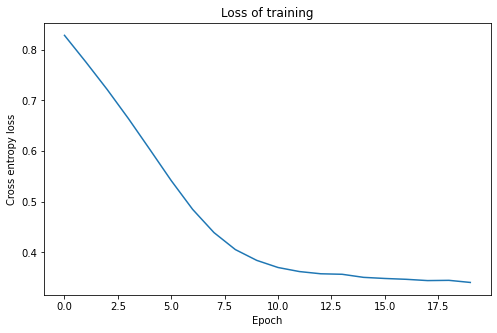

In [39]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 2. SGD Momentum

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [40]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [41]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [42]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [43]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [44]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [45]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [46]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)

#### Train the model

In [47]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 3.3514
Epoch: 001/020 | Batch 1000/1032 | Loss: 1.2336
Epoch: 001/020 Train Loss: 0.6749
Time elapsed: 0.15 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.4212
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.2696
Epoch: 002/020 Train Loss: 0.4080
Time elapsed: 0.31 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.5459
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.2501
Epoch: 003/020 Train Loss: 0.3490
Time elapsed: 0.47 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.2940
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.2054
Epoch: 004/020 Train Loss: 0.3416
Time elapsed: 0.64 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.3223
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.1523
Epoch: 005/020 Train Loss: 0.3294
Time elapsed: 0.81 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.5993
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.4206
Epoch: 006/020 Train Loss: 0.3238
Time elapsed: 0.98 min
Epoch: 007/020 | Batch 000/1032 | Loss: 1.0208
Epoch: 007/020 | Batch 1000/1032 | Loss: 

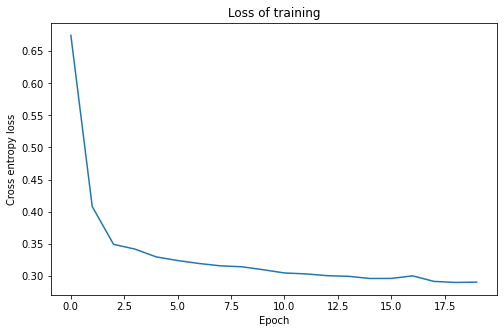

In [48]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 3. SGD Nesterov

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [49]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [50]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [51]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [52]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [53]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [54]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [55]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7, nesterov=True)

#### Train the model

In [56]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 2.8984
Epoch: 001/020 | Batch 1000/1032 | Loss: 0.2925
Epoch: 001/020 Train Loss: 0.7641
Time elapsed: 0.19 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.6939
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.8079
Epoch: 002/020 Train Loss: 0.5912
Time elapsed: 0.42 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.5546
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.4145
Epoch: 003/020 Train Loss: 0.4304
Time elapsed: 0.67 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.6051
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.2426
Epoch: 004/020 Train Loss: 0.3626
Time elapsed: 0.92 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.3949
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.1462
Epoch: 005/020 Train Loss: 0.3453
Time elapsed: 1.16 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.2308
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.1099
Epoch: 006/020 Train Loss: 0.3390
Time elapsed: 1.43 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.1840
Epoch: 007/020 | Batch 1000/1032 | Loss: 

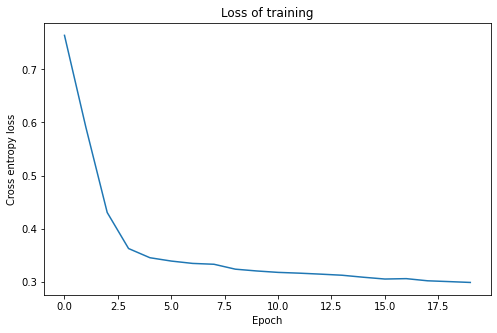

In [57]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 4. Adam

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [58]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [59]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [60]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [61]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [62]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [63]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [64]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the model

In [65]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 4.6069
Epoch: 001/020 | Batch 1000/1032 | Loss: 0.0770
Epoch: 001/020 Train Loss: 0.3160
Time elapsed: 0.27 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.1132
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.3955
Epoch: 002/020 Train Loss: 0.2976
Time elapsed: 0.58 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.4828
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.2019
Epoch: 003/020 Train Loss: 0.2691
Time elapsed: 0.91 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.3740
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.2678
Epoch: 004/020 Train Loss: 0.2813
Time elapsed: 1.25 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.2356
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.0635
Epoch: 005/020 Train Loss: 0.2606
Time elapsed: 1.61 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.7365
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.3318
Epoch: 006/020 Train Loss: 0.2443
Time elapsed: 1.98 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.6334
Epoch: 007/020 | Batch 1000/1032 | Loss: 

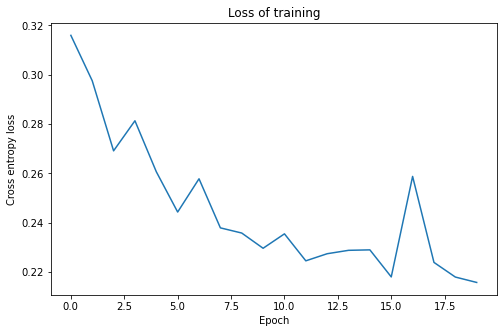

In [66]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 5. Adagrad

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [67]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [68]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [69]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [70]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [71]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [72]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [73]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

#### Train the model

In [74]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 3.3246
Epoch: 001/020 | Batch 1000/1032 | Loss: 0.7844
Epoch: 001/020 Train Loss: 0.5765
Time elapsed: 0.20 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.6188
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.9644
Epoch: 002/020 Train Loss: 0.4286
Time elapsed: 0.41 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.2784
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.2539
Epoch: 003/020 Train Loss: 0.3788
Time elapsed: 0.60 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.2456
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.2595
Epoch: 004/020 Train Loss: 0.3580
Time elapsed: 0.81 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.2098
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.6353
Epoch: 005/020 Train Loss: 0.3497
Time elapsed: 1.04 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.3242
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.2614
Epoch: 006/020 Train Loss: 0.3449
Time elapsed: 1.24 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.3848
Epoch: 007/020 | Batch 1000/1032 | Loss: 

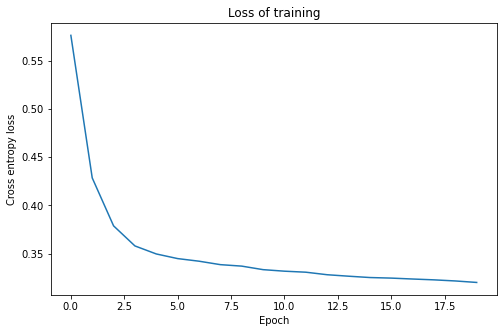

In [75]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 6. Adadelta

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [76]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [77]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [78]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [79]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [80]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [81]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [82]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

#### Train the model

In [83]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 2.3211
Epoch: 001/020 | Batch 1000/1032 | Loss: 2.0171
Epoch: 001/020 Train Loss: 2.0566
Time elapsed: 0.26 min
Epoch: 002/020 | Batch 000/1032 | Loss: 1.5027
Epoch: 002/020 | Batch 1000/1032 | Loss: 1.5708
Epoch: 002/020 Train Loss: 1.4384
Time elapsed: 0.54 min
Epoch: 003/020 | Batch 000/1032 | Loss: 2.1479
Epoch: 003/020 | Batch 1000/1032 | Loss: 1.5693
Epoch: 003/020 Train Loss: 1.1021
Time elapsed: 0.83 min
Epoch: 004/020 | Batch 000/1032 | Loss: 1.0766
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.8708
Epoch: 004/020 Train Loss: 0.9429
Time elapsed: 1.09 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.5891
Epoch: 005/020 | Batch 1000/1032 | Loss: 1.0148
Epoch: 005/020 Train Loss: 0.8777
Time elapsed: 1.35 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.5960
Epoch: 006/020 | Batch 1000/1032 | Loss: 1.4631
Epoch: 006/020 Train Loss: 0.8530
Time elapsed: 1.61 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.4974
Epoch: 007/020 | Batch 1000/1032 | Loss: 

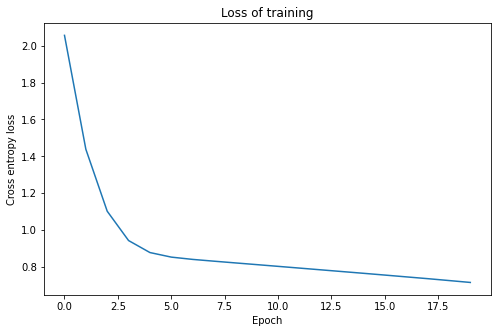

In [84]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 7. Adamax

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [85]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [86]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [87]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [88]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [89]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [90]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [91]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

#### Train the model

In [92]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 2.9181
Epoch: 001/020 | Batch 1000/1032 | Loss: 0.5126
Epoch: 001/020 Train Loss: 0.3360
Time elapsed: 0.34 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.2085
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.0740
Epoch: 002/020 Train Loss: 0.3137
Time elapsed: 0.70 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.1669
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.3951
Epoch: 003/020 Train Loss: 0.3044
Time elapsed: 1.08 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.2825
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.1636
Epoch: 004/020 Train Loss: 0.2944
Time elapsed: 1.47 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.1395
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.1989
Epoch: 005/020 Train Loss: 0.2955
Time elapsed: 1.85 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.3152
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.2740
Epoch: 006/020 Train Loss: 0.2765
Time elapsed: 2.21 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.1333
Epoch: 007/020 | Batch 1000/1032 | Loss: 

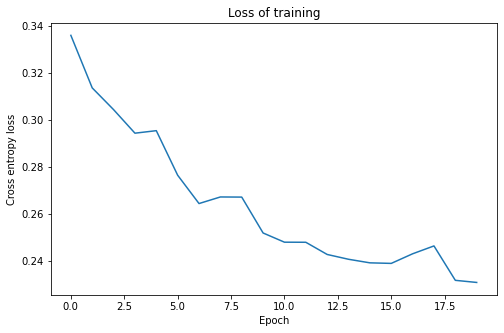

In [93]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 8. RMSprop

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [94]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [95]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [96]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [97]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [98]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [99]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 500]           6,500
              ReLU-2               [-1, 1, 500]               0
            Linear-3              [-1, 1, 1000]         501,000
           Dropout-4              [-1, 1, 1000]               0
              ReLU-5              [-1, 1, 1000]               0
            Linear-6               [-1, 1, 200]         200,200
              ReLU-7               [-1, 1, 200]               0
            Linear-8                 [-1, 1, 1]             201
Total params: 707,901
Trainable params: 707,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.70
Estimated Total Size (MB): 2.73
----------------------------------------------------------------


In [100]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

#### Train the model

In [101]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 2.7866
Epoch: 001/020 | Batch 1000/1032 | Loss: 0.7715
Epoch: 001/020 Train Loss: 0.3094
Time elapsed: 0.21 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.3079
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.2256
Epoch: 002/020 Train Loss: 0.3141
Time elapsed: 0.42 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.1065
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.1504
Epoch: 003/020 Train Loss: 0.2641
Time elapsed: 0.63 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.4925
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.0729
Epoch: 004/020 Train Loss: 0.2921
Time elapsed: 0.83 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.1419
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.2437
Epoch: 005/020 Train Loss: 0.2525
Time elapsed: 1.04 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.2530
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.1168
Epoch: 006/020 Train Loss: 0.2502
Time elapsed: 1.29 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.2224
Epoch: 007/020 | Batch 1000/1032 | Loss: 

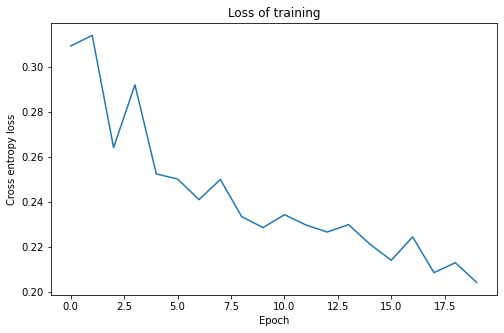

In [102]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Batch normalization

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU activation)

### Create model class

In [103]:
batch_size = 16
n_iters = 21000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [104]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [105]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.BatchNorm1d1=nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.BatchNorm1d2=nn.BatchNorm1d(hidden_dim2)
        self.dropout1 = nn.Dropout(0.35)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.BatchNorm1d1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.BatchNorm1d2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return out

In [106]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 500
hidden_dim2 = 1000
hidden_dim3 = 200

In [107]:
model = FNN(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [110]:
#summary(model, (1,tensor_x.shape[1]))

In [111]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

#### Train the model

In [112]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/020 | Batch 000/1032 | Loss: 8.2336
Epoch: 001/020 | Batch 1000/1032 | Loss: 0.3143
Epoch: 001/020 Train Loss: 0.2974
Time elapsed: 0.55 min
Epoch: 002/020 | Batch 000/1032 | Loss: 0.4679
Epoch: 002/020 | Batch 1000/1032 | Loss: 0.3512
Epoch: 002/020 Train Loss: 0.2738
Time elapsed: 1.10 min
Epoch: 003/020 | Batch 000/1032 | Loss: 0.2887
Epoch: 003/020 | Batch 1000/1032 | Loss: 0.3635
Epoch: 003/020 Train Loss: 0.2573
Time elapsed: 1.63 min
Epoch: 004/020 | Batch 000/1032 | Loss: 0.8143
Epoch: 004/020 | Batch 1000/1032 | Loss: 0.2733
Epoch: 004/020 Train Loss: 0.2445
Time elapsed: 2.16 min
Epoch: 005/020 | Batch 000/1032 | Loss: 0.3705
Epoch: 005/020 | Batch 1000/1032 | Loss: 0.3240
Epoch: 005/020 Train Loss: 0.2776
Time elapsed: 2.73 min
Epoch: 006/020 | Batch 000/1032 | Loss: 0.3705
Epoch: 006/020 | Batch 1000/1032 | Loss: 0.1637
Epoch: 006/020 Train Loss: 0.2544
Time elapsed: 3.31 min
Epoch: 007/020 | Batch 000/1032 | Loss: 0.1770
Epoch: 007/020 | Batch 1000/1032 | Loss: 

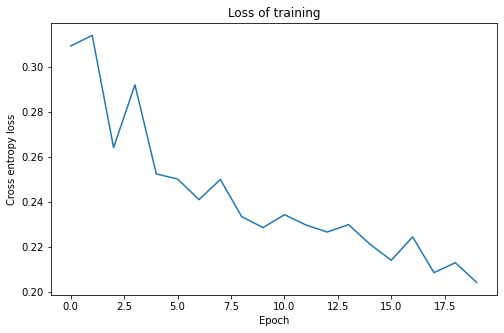

In [102]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Results of regularizations

| Model Name                    | Training Loss | Test Loss | Training Loss(Dropout) | Test Loss(Dropout) | 
|--------------------------------|----------|----------|----------|----------|
| Model B |  0.35  |  0.35 | 0.34  |  0.35 |
| Model C |   0.34  |  0.35 |  0.34  |  0.35 |
| Model D |  0.24  |  0.27  |  0.25  |  0.28  |

## Results of optimizations (Test loss)
- With dropouts from the regularization part

| Optimizer                    | Model B |
|--------------------------------|----------|
| SGD |  0.35  |
| SGD Momentum |  0.31  | 
| SGD Nesterov |  0.31  | 
| Adam |  0.26  |
| Adagrad |  0.33  |
| Adadelta |  0.70  | 
| Adamax |  0.28  |
| **RMSprop** |  **0.24** | 


### Batch normalozation
- With dropouts from the regularization part
- We employed the best optimizer for the model from the previous table

| Model Name | Optimizer| Training Loss | Test Loss |
|------------|----------|----------|----------|
| Model B |  RMSprop  |  0.21  | 0.25  |
